In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

DATA_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Experiment/data'
MODEL_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Experiment/model'
VAL_TO_IDX_DATA_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Server/data'

In [2]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [3]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [4]:
import json

with open(os.path.join(VAL_TO_IDX_DATA_PATH, 'problemId_to_idx.json'), 'r', encoding = 'utf-8') as f:
    problemId_to_idx = json.load(f)

with open(os.path.join(VAL_TO_IDX_DATA_PATH, 'idx_to_problemId.json'), 'r', encoding = 'utf-8') as f:
    idx_to_problemId = json.load(f)

In [5]:
user_df = pd.read_csv(os.path.join(DATA_PATH, 'user.csv'))

In [6]:
def get_problems_to_idx(problems):
    problems = eval(problems)
    ret = []
    for problemId in problems:
        try: ret.append(problemId_to_idx[problemId])
        except: continue
    return ret

user_df['problems_to_idx'] = user_df['problems'].apply(lambda x : get_problems_to_idx(x))

In [7]:
new_user_df = user_df[user_df['problems_to_idx'].apply(lambda x : True if len(x) >= 1 else False)].reset_index(drop = True)

In [8]:
user_name_to_idx = {}

for idx, user_name in enumerate(new_user_df['user_name'].tolist()):
    user_name_to_idx[user_name] = idx

In [9]:
new_user_df['user_name_to_idx'] = new_user_df['user_name'].apply(lambda x : user_name_to_idx[x])

In [10]:
problems_to_user_list = {}

for idx in range(len(idx_to_problemId)):
    problems_to_user_list[idx] = []

group_df = new_user_df.groupby('user_name_to_idx')

for _user_name_to_idx, df in group_df:
    problems_to_idx = df['problems_to_idx'].values[0]
    for problem_to_idx in problems_to_idx:
        problems_to_user_list[problem_to_idx] += [_user_name_to_idx]

In [11]:
new_user_df['problems_count'].sum() / (len(problemId_to_idx) * len(user_name_to_idx))

0.005441813550932233

In [12]:
train_df = {}
valid_df = {}

for idx in range(len(idx_to_problemId)):
    if len(problems_to_user_list[idx]) >= 15:
        random.seed(22)
        valid_df[idx] = random.sample(problems_to_user_list[idx], 10)
        train_df[idx] = list(set(problems_to_user_list[idx]) - set(valid_df[idx]))
    else:
        train_df[idx] = problems_to_user_list[idx]

In [13]:
class AutoRec(nn.Module):
    def __init__(self, num, num_factor):
        super(AutoRec, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num, num_factor),
            nn.Sigmoid(),
            nn.Linear(num_factor, num_factor // 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(num_factor // 2, num_factor),
            nn.Sigmoid(),
            nn.Linear(num_factor, num),
        )

        self.init_weights()

    def forward(self, mat, calculate_latent = False):
        latent = self.encoder(mat)
        recont_mat = self.decoder(latent)
        if calculate_latent: return latent
        return recont_mat

    def init_weights(self):
        for layer in self.encoder:
            if isinstance(layer, nn.Linear):
                size = layer.weight.size()
                fan_out = size[0]
                fan_in = size[1]
                std = np.sqrt(2.0/(fan_in + fan_out))
                layer.weight.data.normal_(0.0, std)
                layer.bias.data.normal_(0.0, 0.001)
        
        for layer in self.decoder:
            if isinstance(layer, nn.Linear):
                size = layer.weight.size()
                fan_out = size[0]
                fan_in = size[1]
                std = np.sqrt(2.0/(fan_in + fan_out))
                layer.weight.data.normal_(0.0, std)
                layer.bias.data.normal_(0.0, 0.001)

In [14]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.datas = list(df.keys())

    def __len__(self):
        return len(self.datas)

    def __getitem__(self, idx):
        data = self.datas[idx]
        return torch.tensor(data)

In [15]:
def get_hit(pred_list, true_list):
    hit_list = set(true_list) & set(pred_list)
    hit = len(hit_list) / len(true_list)
    return hit

def make_matrix(data):
    mat = torch.zeros(size = (len(data), len(user_name_to_idx)))
    for idx, user in enumerate(data):
        mat[idx, train_df[user.item()]] = 1
    return mat

def train(model, criterion, optimizer, data_loader):
    model.train()
    loss_val = 0
    for data in data_loader:
        mat = make_matrix(data)
        mat = mat.to(device)
        recon_mat = model(mat)

        optimizer.zero_grad()
        loss = criterion(recon_mat, mat)

        loss_val += loss.item()

        loss.backward()
        optimizer.step()
    
    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, data_loader):
    model.eval()

    HIT = 0.0 # HIT@10

    with torch.no_grad():
        for data in data_loader:
            mat = make_matrix(data)
            mat = mat.to(device)

            recon_mat = model(mat)
            recon_mat[mat == 1] = -np.inf
            rec_list = recon_mat.argsort(dim = 1)

            for item, rec in zip(data, rec_list):
                uv = valid_df[item.item()]
                up = rec[-10:].cpu().numpy().tolist()
                HIT += get_hit(pred_list = up, true_list = uv)

    HIT /= len(data_loader.dataset)

    return HIT
    
def predict(model, data_loader):
    model.eval()
    item_vectors = []
    
    with torch.no_grad():
        for data in data_loader:
            mat = torch.zeros(size = (len(data), len(user_name_to_idx)))
            for idx, user in enumerate(data):
                mat[idx, problems_to_user_list[user.item()]] = 1
            mat = mat.to(device)

            latent_mat = model(mat, calculate_latent = True)

            item_vectors.append(latent_mat.cpu().numpy())
    
    return item_vectors

In [16]:
batch_size = 256
epochs = 100
lr = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_factor = 128
num_workers = 8

model_name = 'item-based-AE'

In [17]:
seed_everything(22)

In [18]:
train_dataset = CustomDataset(df = train_df)
train_data_loader = DataLoader(
        train_dataset, 
        batch_size = batch_size, 
        shuffle = True, 
        drop_last = False,
        num_workers = num_workers)


valid_dataset = CustomDataset(df = valid_df)
valid_data_loader = DataLoader(
        valid_dataset, 
        batch_size = batch_size, 
        shuffle = False, 
        drop_last = False,
        num_workers = num_workers)

In [19]:
model = AutoRec(
    num = len(user_name_to_idx), 
    num_factor = num_factor).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [21]:
best_hit = 0

for epoch in range(1, epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
            train_loss = train(model = model, data_loader = train_data_loader, criterion = criterion, optimizer = optimizer)
            hit = evaluate(model = model, data_loader = valid_data_loader)
            if best_hit < hit:
                best_epoch = epoch
                best_train_loss = train_loss
                best_hit = hit
                torch.save(model.state_dict(), os.path.join(MODEL_PATH, model_name + '.pt'))

            tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| HIT@10: {hit:.5f}')
    
print(f'BEST | Epoch: {best_epoch:3d}| Train loss: {best_train_loss:.5f}| HIT@10: {best_hit:.5f}')

Epoch:   1| Train loss: 0.00418| HIT@10: 0.16288: 100%|██████████| 1/1 [00:06<00:00,  6.76s/it]
Epoch:   2| Train loss: 0.00322| HIT@10: 0.16751: 100%|██████████| 1/1 [00:06<00:00,  6.67s/it]
Epoch:   3| Train loss: 0.00302| HIT@10: 0.17363: 100%|██████████| 1/1 [00:06<00:00,  6.53s/it]
Epoch:   4| Train loss: 0.00291| HIT@10: 0.17551: 100%|██████████| 1/1 [00:06<00:00,  6.61s/it]
Epoch:   5| Train loss: 0.00285| HIT@10: 0.17817: 100%|██████████| 1/1 [00:06<00:00,  6.52s/it]
Epoch:   6| Train loss: 0.00283| HIT@10: 0.18444: 100%|██████████| 1/1 [00:06<00:00,  6.88s/it]
Epoch:   7| Train loss: 0.00278| HIT@10: 0.19105: 100%|██████████| 1/1 [00:08<00:00,  8.08s/it]
Epoch:   8| Train loss: 0.00273| HIT@10: 0.19298: 100%|██████████| 1/1 [00:07<00:00,  7.03s/it]
Epoch:   9| Train loss: 0.00273| HIT@10: 0.19785: 100%|██████████| 1/1 [00:07<00:00,  7.18s/it]
Epoch:  10| Train loss: 0.00272| HIT@10: 0.19893: 100%|██████████| 1/1 [00:07<00:00,  7.15s/it]
Epoch:  11| Train loss: 0.00264| HIT@10:

In [19]:
dataset = CustomDataset(df = problems_to_user_list)
data_loader = DataLoader(
        dataset, 
        batch_size = batch_size, 
        shuffle = False, 
        drop_last = False,
        num_workers = num_workers)

model = AutoRec(
    num = len(user_name_to_idx), 
    num_factor = num_factor).to(device)

model.load_state_dict(torch.load(os.path.join(MODEL_PATH, model_name + '.pt')))

<All keys matched successfully>

In [24]:
item_vectors = np.concatenate(predict(model = model, data_loader = data_loader))

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state = 0)
new_arr = tsne.fit_transform(item_vectors)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


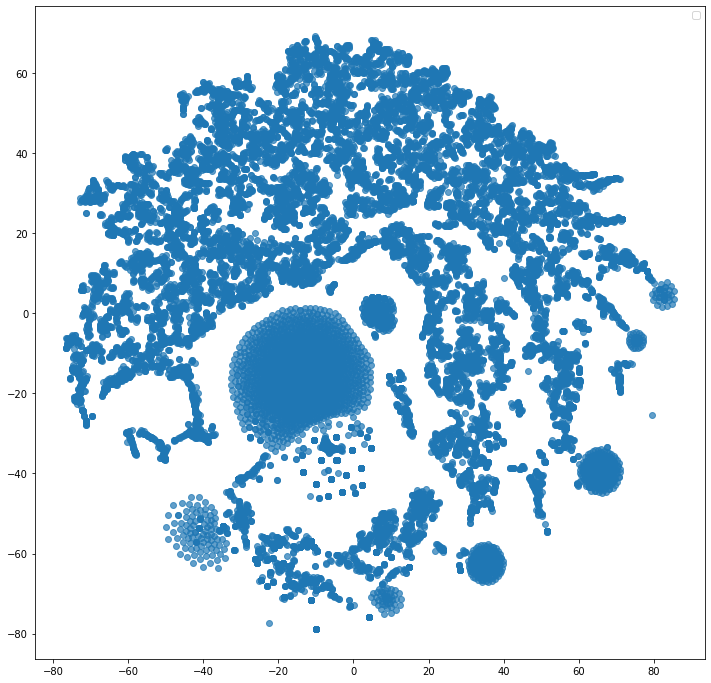

In [26]:
# Word2Vec-CBOW-problem_association_seq-problem_level_seq-problem_tag_seq-vs128-model

import matplotlib.pyplot as plt

plt.figure(figsize = (12, 12))
plt.scatter(new_arr[:, 0], new_arr[:, 1], alpha = 0.7) 
plt.legend()
plt.show()